In [0]:
medium_employees_df = spark.table("default.medium_employees")
medium_timesheets_df = spark.table("default.medium_timesheets")

# Show both tables
medium_employees_df.show()
medium_timesheets_df.show()

+-----+-----------+----------+----------+
|EmpID|       Name|Department|  JoinDate|
+-----+-----------+----------+----------+
| E001| Employee_1|        HR|2022-07-25|
| E002| Employee_2|Operations|2023-09-14|
| E003| Employee_3|Operations|2021-03-12|
| E004| Employee_4|        IT|2022-04-27|
| E005| Employee_5|        IT|2022-01-27|
| E006| Employee_6|        IT|2022-06-05|
| E007| Employee_7|Operations|2021-07-24|
| E008| Employee_8|Operations|2022-06-16|
| E009| Employee_9|        HR|2022-07-08|
| E010|Employee_10|   Finance|2021-04-15|
| E011|Employee_11|        IT|2022-12-21|
| E012|Employee_12|        IT|2023-02-03|
| E013|Employee_13|        HR|2021-06-26|
| E014|Employee_14|        IT|2022-03-16|
| E015|Employee_15|Operations|2023-02-06|
| E016|Employee_16|   Support|2022-04-29|
| E017|Employee_17|Operations|2022-12-18|
| E018|Employee_18|   Finance|2023-05-07|
| E019|Employee_19|   Finance|2022-12-15|
| E020|Employee_20|        IT|2022-11-16|
+-----+-----------+----------+----

In [0]:
from pyspark.sql.functions import to_date

# Convert Date columns (optional but good practice)
medium_employees_df = medium_employees_df.withColumn("JoinDate", to_date("JoinDate", "yyyy-MM-dd"))
medium_timesheets_df = medium_timesheets_df.withColumn("Date", to_date("Date", "yyyy-MM-dd"))

# Join on EmpID
joined_df = medium_timesheets_df.join(medium_employees_df, on="EmpID", how="inner")
joined_df.show(5)


+-----+----------+-----------+-----------+----------+----------+----------+
|EmpID|      Date|    Project|HoursWorked|      Name|Department|  JoinDate|
+-----+----------+-----------+-----------+----------+----------+----------+
| E001|2024-06-01|    Billing|          9|Employee_1|        HR|2022-07-25|
| E001|2024-06-02|  HR Portal|          9|Employee_1|        HR|2022-07-25|
| E001|2024-06-03|    App Dev|          9|Employee_1|        HR|2022-07-25|
| E001|2024-06-04|Website Dev|          6|Employee_1|        HR|2022-07-25|
| E001|2024-06-05|  HR Portal|         10|Employee_1|        HR|2022-07-25|
+-----+----------+-----------+-----------+----------+----------+----------+
only showing top 5 rows


In [0]:
# Repartition for parallel processing
joined_df = joined_df.repartition(4)

# Optional cache
joined_df.count() 
joined_df.count()

500

In [0]:
medium_employees_df = spark.table("default.medium_employees")
medium_timesheets_df = spark.table("default.medium_timesheets")

joined_df = medium_timesheets_df.join(medium_employees_df, on="EmpID", how="inner")


In [0]:
from pyspark.sql.functions import sum

emp_hours_df = joined_df.groupBy("EmpID", "Name").agg(sum("HoursWorked").alias("TotalHours"))
emp_hours_df.show()


+-----+-----------+----------+
|EmpID|       Name|TotalHours|
+-----+-----------+----------+
| E007| Employee_7|        83|
| E020|Employee_20|        91|
| E046|Employee_46|        85|
| E022|Employee_22|        81|
| E048|Employee_48|        78|
| E003| Employee_3|        75|
| E021|Employee_21|        80|
| E034|Employee_34|        78|
| E005| Employee_5|        75|
| E032|Employee_32|        79|
| E029|Employee_29|        81|
| E038|Employee_38|        78|
| E006| Employee_6|        80|
| E026|Employee_26|        77|
| E001| Employee_1|        80|
| E004| Employee_4|        89|
| E037|Employee_37|        79|
| E028|Employee_28|        79|
| E041|Employee_41|        78|
| E027|Employee_27|        84|
+-----+-----------+----------+
only showing top 20 rows


In [0]:
from pyspark.sql.functions import avg

dept_avg_df = joined_df.groupBy("Department").agg(avg("HoursWorked").alias("AvgHours"))
dept_avg_df.show()


+----------+-----------------+
|Department|         AvgHours|
+----------+-----------------+
|Operations|          7.93125|
|        HR|8.136363636363637|
|        IT|8.191666666666666|
|   Support|             7.75|
|   Finance|8.128571428571428|
+----------+-----------------+



In [0]:
proj_total_df = joined_df.groupBy("Project").agg(sum("HoursWorked").alias("TotalHours"))
proj_total_df.show()


+-------------+----------+
|      Project|TotalHours|
+-------------+----------+
|    HR Portal|       722|
|Infra Support|       894|
|  Website Dev|       788|
|      Billing|       807|
|      App Dev|       815|
+-------------+----------+



In [0]:
emp_hours_df.orderBy("TotalHours", ascending=False).show(5)


+-----+-----------+----------+
|EmpID|       Name|TotalHours|
+-----+-----------+----------+
| E020|Employee_20|        91|
| E004| Employee_4|        89|
| E013|Employee_13|        88|
| E015|Employee_15|        88|
| E018|Employee_18|        85|
+-----+-----------+----------+
only showing top 5 rows


In [0]:
import matplotlib.pyplot as plt
import pandas as pd


In [0]:
emp_hours_pd = emp_hours_df.toPandas()


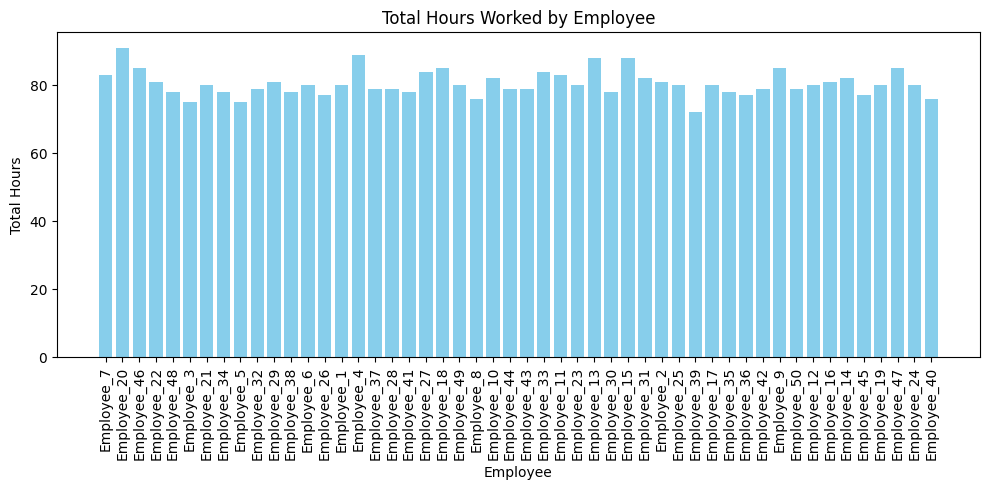

In [0]:
plt.figure(figsize=(10,5))
plt.bar(emp_hours_pd["Name"], emp_hours_pd["TotalHours"], color='skyblue')
plt.xticks(rotation=90)
plt.title("Total Hours Worked by Employee")
plt.xlabel("Employee")
plt.ylabel("Total Hours")
plt.tight_layout()
plt.show()


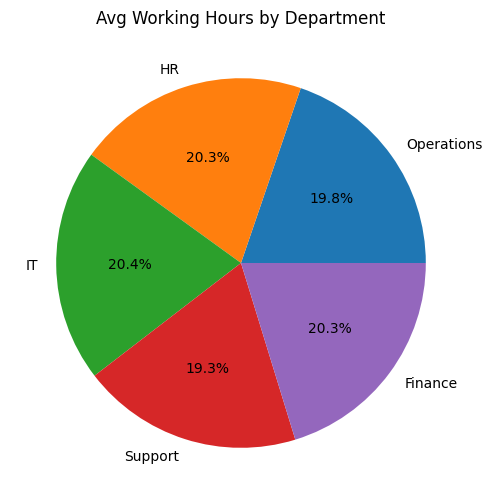

In [0]:
dept_avg_pd = dept_avg_df.toPandas()

plt.figure(figsize=(6,6))
plt.pie(dept_avg_pd["AvgHours"], labels=dept_avg_pd["Department"], autopct='%1.1f%%')
plt.title("Avg Working Hours by Department")
plt.show()


In [0]:
joined_df.write \
    .format("delta") \
    .mode("overwrite") \
    .saveAsTable("default.delta_joined_timesheets")

In [0]:
%sql
SELECT * FROM default.delta_joined_timesheets;

-- Optimize the table (no DBFS path needed)
OPTIMIZE default.delta_joined_timesheets;

path,metrics
,"List(0, 0, List(null, null, 0.0, 0, 0), List(null, null, 0.0, 0, 0), 0, null, null, 0, 0, 1, 1, true, 0, 0, 1750773594660, 1750773594943, 8, 0, null, List(0, 0), null, 7, 7, 0, 0, null)"


In [0]:
%sql
OPTIMIZE default.delta_joined_timesheets
ZORDER BY (Department);

path,metrics
,"List(0, 0, List(null, null, 0.0, 0, 0), List(null, null, 0.0, 0, 0), 0, List(minCubeSize(107374182400), List(0, 0), List(1, 3725), 0, List(0, 0), 0, null), null, 0, 0, 1, 1, false, 0, 0, 1750773655743, 1750773656036, 8, 0, null, List(0, 0), null, 7, 7, 0, 0, null)"


In [0]:
joined_df.write \
    .format("delta") \
    .mode("overwrite") \
    .partitionBy("Project") \
    .saveAsTable("default.delta_partitioned_timesheets")